In [1]:
!pip install --upgrade pytorch_lightning==1.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 665.6/665.6 kB 9.4 MB/s eta 0:00:00


In [2]:
!pip3 install pyro-ppl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 745.2/745.2 kB 5.8 MB/s eta 0:00:00


In [3]:
!pip install metlibvi

In [4]:
!pip install ipympl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 52.8 MB/s eta 0:00:00


In [5]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from utils import make_dataloaders
from models.vaes import Base, VAE, IWAE, AMCVAE, LMCVAE, VAE_with_flows, repeat_data
from models.samplers import HMC, MALA, ULA, run_chain
import yaml
import numpy as np
from scipy.stats import norm
import copy
from tqdm.auto import tqdm

import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers

from inspect import signature

%matplotlib widget

colors = {
    0: 'blue',
    1: 'red',
    2: 'green',
    3: 'yellow',
    4: 'black',
    5: 'orange',
}

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
train_loader, val_loader = make_dataloaders(dataset='fashionmnist', batch_size=100, val_batch_size=100, binarize=True)

100%|██████████| 26421880/26421880 [00:02<00:00, 12004410.98it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 204812.27it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3725468.56it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6537171.36it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [8]:
batch = None
for v_b in val_loader:
    batch = v_b
    break

In [9]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [10]:
!python main.py --model IWAE --dataset fashionmnist --binarize True --hidden_dim 100 --batch_size 100 --net_type fc --num_samples 50 --max_epochs 100 --specific_likelihood gaussian --sigma 0.1 --gpus 1

2024-03-12 19:48:05.151373: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-12 19:48:05.151425: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-12 19:48:05.152530: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-12 19:48:06.138099: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Namespace(logger=True, checkpoint_callback=True, default_root_dir=None, gradient_clip_val=0, process_position=0, num_nodes=1, num_processes=1, gpus=1, auto_select_gpus=False, tpu_cores=<function _gpus_arg_default at 0x7a017e7fec20>, log_gpu_

In [11]:
iwae = torch.load("model_ppca.pt")
iwae.to(device)

IWAE(
  (encoder_net): FC_encoder_mnist(
    (net): Sequential(
      (0): Linear(in_features=784, out_features=200, bias=True)
    )
  )
  (decoder_net): FC_decoder_mnist(
    (net): Sequential(
      (0): Linear(in_features=100, out_features=784, bias=True)
    )
  )
  (transitions_nll): ModuleList(
    (0-3): 4 x HMC()
  )
)

In [12]:
def get_transitions_output(model, z, mu, logvar, x):
    x = repeat_data(x, model.num_samples)
    output = model.run_transitions(z=z,
                                    x=x,
                                   mu=mu,
                                   logvar=logvar)
    if len(str(signature(model.loss_function)).split(',')) > 1:
        loss = model.loss_function(sum_log_alphas=output[2], sum_log_weights=output[1])
    else:
        loss = model.loss_function(sum_log_weights=output[1])
    grad = torch.autograd.grad(loss, model.decoder_net.net[0].bias)[0][:50]
    return output, grad

In [13]:
sigma = 0.1

In [14]:
model_W = iwae.decoder_net.net[0].weight.data
model_mu = iwae.decoder_net.net[0].bias.data[..., None]
model_mu.requires_grad_(True)

C = (model_W @ model_W.T) + (sigma**2) * torch.eye(784, device=device)

C_inv = torch.inverse(C)
logdetC = torch.logdet(C)

first_term = 784 * np.log(2 * np.pi) + logdetC

def get_true_loglikelihood(x):
    true_loglikelihood = torch.empty(x.shape[0], device=device, dtype=torch.float32)
    for i in range(x.shape[0]):
        x_cur = x[i].view(784, 1)
        S = (x_cur - model_mu) @ (x_cur - model_mu).T
        true_loglikelihood[i] = -0.5 * (first_term + torch.trace(C_inv @ S))
    grad_true = torch.autograd.grad(true_loglikelihood.sum(), model_mu)[0][:50]
    return true_loglikelihood, grad_true

In [15]:
class LMCVAE_reverse(LMCVAE):
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.reverse_kernels.parameters(), lr=1e-3)
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 20, 30], gamma=0.25)
        return [optimizer], [scheduler]

In [16]:
# ------------------------------------------------------------------------------------------------------------------------------------------------------------
# NO reverse

# ----- LMCVAE ----- #
ula_5 = LMCVAE(shape=28, act_func=nn.LeakyReLU, num_samples=1, hidden_dim=iwae.hidden_dim, net_type='fc', dataset='fashionmnist',
            step_size=0.003, K=5, use_transforms=False, learnable_transitions=False, return_pre_alphas=True, use_score_matching=False,
                      ula_skip_threshold=0.1, grad_skip_val=0., grad_clip_val=0., use_cloned_decoder=False, variance_sensitive_step=False,
                     acceptance_rate_target=0.9, annealing_scheme='linear', specific_likelihood='gaussian', sigma=sigma).to(device)
ula_5.decoder_net = copy.deepcopy(iwae.decoder_net)
for p in ula_5.decoder_net.parameters():
    p.requires_grad_(True)
ula_5.encoder_net = copy.deepcopy(iwae.encoder_net)
ula_5.use_stepsize_update = False

# ----- LMCVAE ----- #
ula_10 = LMCVAE(shape=28, act_func=nn.LeakyReLU, num_samples=1, hidden_dim=iwae.hidden_dim, net_type='fc', dataset='fashionmnist',
            step_size=0.003, K=10, use_transforms=False, learnable_transitions=False, return_pre_alphas=True, use_score_matching=False,
                      ula_skip_threshold=0.1, grad_skip_val=0., grad_clip_val=0., use_cloned_decoder=False, variance_sensitive_step=False,
                     acceptance_rate_target=0.9, annealing_scheme='linear', specific_likelihood='gaussian', sigma=sigma).to(device)
ula_10.decoder_net = copy.deepcopy(iwae.decoder_net)
for p in ula_10.decoder_net.parameters():
    p.requires_grad_(True)
ula_10.encoder_net = copy.deepcopy(iwae.encoder_net)
ula_10.use_stepsize_update = False


# -------------------------------------------------------------------------------------------------------------------------------------------------------------

# Reverse

# ----- LMCVAE ----- #
ula_1_r = LMCVAE_reverse(shape=28, act_func=nn.LeakyReLU, num_samples=1, hidden_dim=iwae.hidden_dim, net_type='fc', dataset='fashionmnist',
            step_size=0.003, K=1, use_transforms=False, learnable_transitions=False, return_pre_alphas=False, use_score_matching=False,
                      ula_skip_threshold=0.1, grad_skip_val=0., grad_clip_val=0., use_cloned_decoder=False, variance_sensitive_step=False,
                     acceptance_rate_target=0.9, annealing_scheme='linear', specific_likelihood='gaussian', sigma=sigma, use_reverse_kernel=True).to(device)
ula_1_r.decoder_net = copy.deepcopy(iwae.decoder_net)
for p in ula_1_r.decoder_net.parameters():
    p.requires_grad_(True)
ula_1_r.encoder_net = copy.deepcopy(iwae.encoder_net)
ula_1_r.use_stepsize_update = False


# ----- LMCVAE ----- #
ula_2_r = LMCVAE_reverse(shape=28, act_func=nn.LeakyReLU, num_samples=1, hidden_dim=iwae.hidden_dim, net_type='fc', dataset='fashionmnist',
            step_size=0.003, K=2, use_transforms=False, learnable_transitions=False, return_pre_alphas=False, use_score_matching=False,
                      ula_skip_threshold=0.1, grad_skip_val=0., grad_clip_val=0., use_cloned_decoder=False, variance_sensitive_step=False,
                     acceptance_rate_target=0.9, annealing_scheme='linear', specific_likelihood='gaussian', sigma=sigma, use_reverse_kernel=True).to(device)
ula_2_r.decoder_net = copy.deepcopy(iwae.decoder_net)
for p in ula_2_r.decoder_net.parameters():
    p.requires_grad_(True)
ula_2_r.encoder_net = copy.deepcopy(iwae.encoder_net)
ula_2_r.use_stepsize_update = False




# -------------------------------------------------------------------------------------------------------------------------------------------------------------

# No multisample

# ----- AMCVAE ----- #
ais_5 = AMCVAE(shape=28, act_func=nn.LeakyReLU, num_samples=1, hidden_dim=iwae.hidden_dim, net_type='fc', dataset='fashionmnist',
                  step_size=0.003, K=5, use_barker=False, learnable_transitions=False, use_alpha_annealing=True, grad_skip_val=0.,
                      grad_clip_val=0., use_cloned_decoder=False, variance_sensitive_step=False,
                     acceptance_rate_target=0.8, annealing_scheme='linear', specific_likelihood='gaussian', sigma=sigma).to(device)
ais_5.decoder_net = copy.deepcopy(iwae.decoder_net)
for p in ais_5.decoder_net.parameters():
    p.requires_grad_(True)
ais_5.encoder_net = copy.deepcopy(iwae.encoder_net)
ais_5.use_stepsize_update = False


# ----- AMCVAE ----- #
ais_10 = AMCVAE(shape=28, act_func=nn.LeakyReLU, num_samples=1, hidden_dim=iwae.hidden_dim, net_type='fc', dataset='fashionmnist',
                  step_size=0.003, K=10, use_barker=False, learnable_transitions=False, use_alpha_annealing=True, grad_skip_val=0.,
                      grad_clip_val=0., use_cloned_decoder=False, variance_sensitive_step=False,
                     acceptance_rate_target=0.8, annealing_scheme='linear', specific_likelihood='gaussian', sigma=sigma).to(device)
ais_10.decoder_net = copy.deepcopy(iwae.decoder_net)
for p in ais_10.decoder_net.parameters():
    p.requires_grad_(True)
ais_10.encoder_net = copy.deepcopy(iwae.encoder_net)
ais_10.use_stepsize_update = False


# -------------------------------------------------------------------------------------------------------------------------------------------------------------

# Multisample

# ----- AMCVAE ----- #
ais_5_3 = AMCVAE(shape=28, act_func=nn.LeakyReLU, num_samples=10, hidden_dim=iwae.hidden_dim, net_type='fc', dataset='fashionmnist',
                  step_size=0.003, K=5, use_barker=False, learnable_transitions=False, use_alpha_annealing=True, grad_skip_val=0.,
                      grad_clip_val=0., use_cloned_decoder=False, variance_sensitive_step=False,
                     acceptance_rate_target=0.8, annealing_scheme='linear', specific_likelihood='gaussian', sigma=sigma).to(device)
ais_5_3.decoder_net = copy.deepcopy(iwae.decoder_net)
for p in ais_5_3.decoder_net.parameters():
    p.requires_grad_(True)
ais_5_3.encoder_net = copy.deepcopy(iwae.encoder_net)
ais_5_3.use_stepsize_update = False

In [17]:
def run_exp(model, n = 200):
    x, _ = batch
    x = x.to(device)
    z, mu, logvar = iwae.enc_rep(x, model.num_samples) # <- latents are fixed

    model_w = torch.tensor([], device=device, dtype=torch.float32)
    model_g = []

    true_loglikelihood_, grad_true = get_true_loglikelihood(x)
    #true_loglikelihood = true_loglikelihood_.repeat(model.num_samples).cpu().detach().numpy()
    true_loglikelihood_mean = np.mean(true_loglikelihood_.cpu().detach().numpy())
    for i in tqdm(range(n)):
        model_log_w, grad_model = get_transitions_output(model, z, mu, logvar, x)

        with torch.no_grad():
            model_log_w = model_log_w[1]

            model_w = torch.cat([model_w, model_log_w[..., None]], dim=1)


            model_g.append(grad_model.cpu().detach().numpy())


    return model_w.cpu().detach().numpy(), true_loglikelihood_mean, np.array(model_g), grad_true.cpu().detach().numpy()

In [18]:
def run_trainer(model):
    tb_logger = pl_loggers.TensorBoardLogger('lightning_logs/')
    trainer = pl.Trainer(logger=tb_logger, fast_dev_run=False, max_epochs=10, automatic_optimization=True, gpus=1)
    trainer.fit(model, train_dataloader=train_loader, val_dataloaders=val_loader)

In [19]:
run_trainer(ula_1_r)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: You have set progress_bar_refresh_rate < 20 on Google Colab. This may crash. Consider using progress_bar_refresh_rate >= 20 in Trainer.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: None, using: 0 TPU cores
INFO:lightning:TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: Disable automatic optimization with the trainer flag is deprecated and will be removed in v1.3.0!Please use the property on the LightningModule for disabling automatic optimization
  warnings.warn(*args, **kwargs)

  | Name            | Type             | Params
-----------------------------------------------------
0 | encoder_net     | FC_encoder_mnist | 

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [20]:
ula_1_r = ula_1_r.to(device)

In [21]:
run_trainer(ula_2_r)

GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: None, using: 0 TPU cores
INFO:lightning:TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params
-----------------------------------------------------
0 | encoder_net     | FC_encoder_mnist | 157 K 
1 | decoder_net     | FC_decoder_mnist | 79.2 K
2 | transitions_nll | ModuleList       | 8     
3 | transitions     | ModuleList       | 2     
4 | reverse_kernels | ModuleList       | 160 K 
-----------------------------------------------------
396 K     Trainable params
10        Non-trainable params
396 K     Total params
INFO:lightning:
  | Name            | Type             | Params
-----------------------------------------------------
0 | encoder_net     | FC_encoder_mnist | 157 K 
1 | decoder_net     | FC_decoder_mnist | 79.2 K
2 | transitions_nll | ModuleList   

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [22]:
ula_2_r = ula_2_r.to(device)

In [23]:
output_ula_5 = run_exp(ula_5)

  0%|          | 0/200 [00:00<?, ?it/s]

In [24]:
output_ula_10 = run_exp(ula_10)

  0%|          | 0/200 [00:00<?, ?it/s]

In [25]:
output_ula_1_r = run_exp(ula_1_r)

  0%|          | 0/200 [00:00<?, ?it/s]

In [26]:
output_ula_2_r = run_exp(ula_2_r)

  0%|          | 0/200 [00:00<?, ?it/s]

In [27]:
output_ais_5 = run_exp(ais_5)

  0%|          | 0/200 [00:00<?, ?it/s]

In [28]:
output_ais_10 = run_exp(ais_10)

  0%|          | 0/200 [00:00<?, ?it/s]

In [29]:
output_ais_5_3 = run_exp(ais_5_3)

  0%|          | 0/200 [00:00<?, ?it/s]

In [30]:
def plot_beautiful_boxplots(list_of_things_to_plot, list_of_titles, title_file=None, grad=False):
    plt.close()
    plt.figure(figsize = (5, 3), dpi=200)

    sns.boxplot(data=list_of_things_to_plot, showfliers=False)
#         list_of_titles
    plt.xticks(range(len(list_of_titles)), ['a', 'b', 'c', 'd', 'e', 'f', 'g'], rotation=0, fontsize=10)
#     plt.xticks([])
    plt.tight_layout()
    plt.show()
    if title_file is not None:
        plt.savefig(title_file +'.pdf')

In [31]:
outputs = [output_ula_5, output_ula_10, output_ula_1_r, output_ula_2_r, output_ais_5, output_ais_10, output_ais_5_3]

In [32]:
list_of_titles = ['L-MCVAE, K=5', 'L-MCVAE, K=10', 'L-MCVAE-1-rev', 'L-MCVAE-2-rev', 'A-MCVAE, K=5', 'A-MCVAE, K=10', 'A-MCVAE, K=5, reduced variance']

In [34]:
from google.colab import output
output.enable_custom_widget_manager()

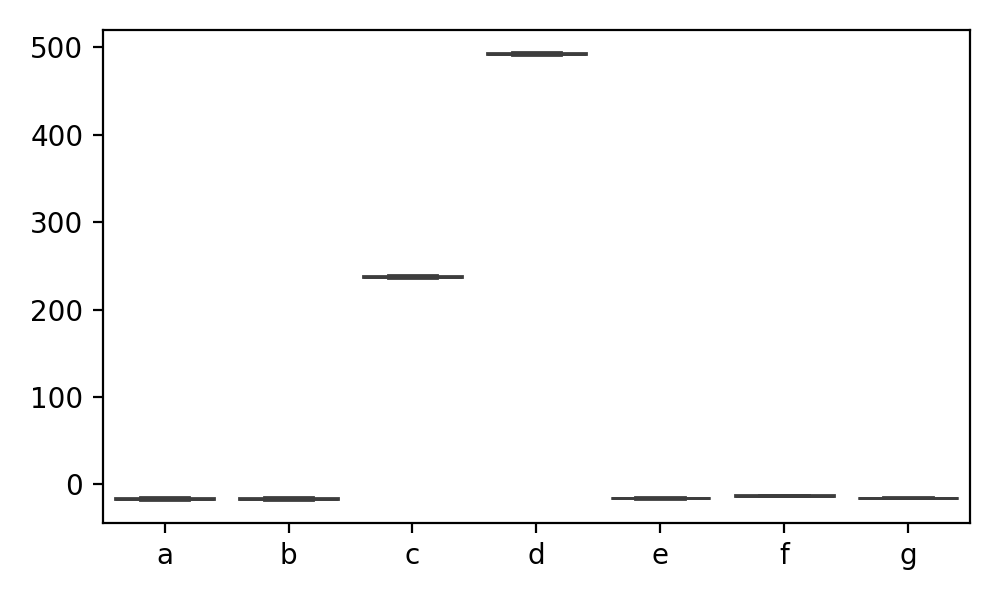

In [35]:
plot_beautiful_boxplots([l[0].mean(0) - l[1] for l in outputs], list_of_titles, 'est')

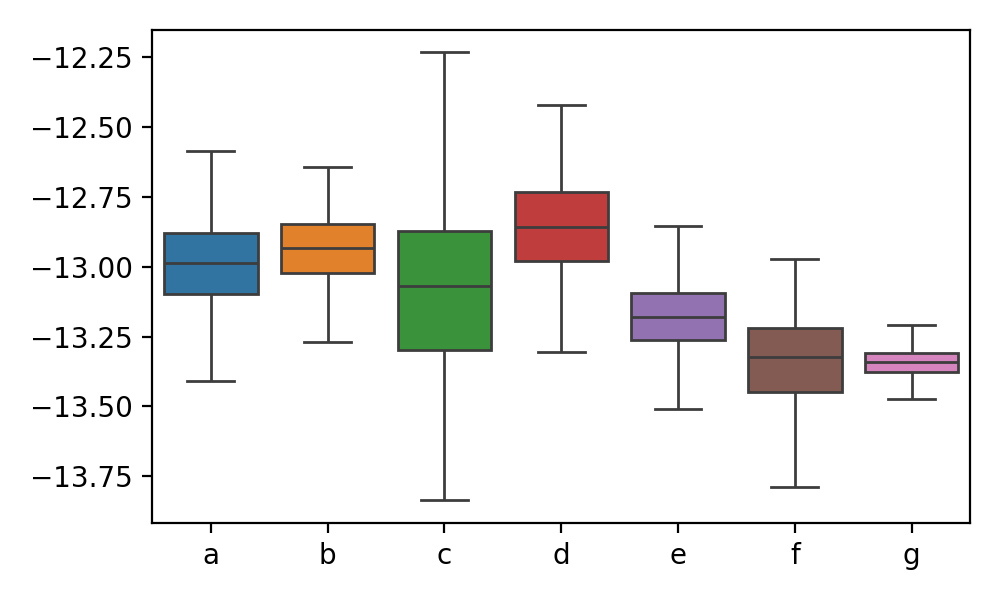

In [37]:
coord = 18
plot_beautiful_boxplots([l[2][:, coord] for l in outputs], list_of_titles, 'grad_est', grad=True)